In [3]:
import pybullet as p
import pybullet_data
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time

class FrankaReachEnv(gym.Env):
    def __init__(self, render=False):
        self.render = render
        if not p.isConnected():
            self.physicsClient = p.connect(p.GUI if render else p.DIRECT)
        self.timestep = 1 / 240.
        self.max_steps = 5000
        self.step_count = 0
        self.robot_id = None
        self.target_pos = np.array([0.5, 0.0, 0.6]) # target position in cartesian space
        self.target_ori_euler = p.getQuaternionFromEuler([0, np.pi, 0]) # target orientation in cartesian space
        self.action_space = spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)
        obs_low = np.array([-np.pi] * 7 )
        obs_high = np.array([np.pi] * 7)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self, seed=None, options=None):
        if not p.isConnected():
            self.physicsClient = p.connect(p.GUI if self.render else p.DIRECT)

        p.resetSimulation()
        self.step_count = 0
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)
        p.loadURDF("plane.urdf")
        self.robot_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True)
        init_q = np.array([0, -0.785398163397, 0, -2.3561944901, 0, 1.57079632679, 0.785398163397])
        for i in range(7):
            p.resetJointState(self.robot_id, i, init_q[i]) # initial joint angle
            p.setJointMotorControl2(self.robot_id, i, controlMode=p.VELOCITY_CONTROL, force=0) # cancel position control
        for _ in range(10):
            p.stepSimulation()
        obs_data = self._get_obs()

        return obs_data['flat_obs'], {}

    def _get_obs(self):
        # Get joint information
        num_joints = p.getNumJoints(self.robot_id)
        joint_indices = [i for i in range(num_joints) if p.getJointInfo(self.robot_id, i)[2] != p.JOINT_FIXED]
        num_dof = len(joint_indices)
        joint_states = p.getJointStates(self.robot_id, joint_indices)
        joint_positions = [s[0] for s in joint_states]
        joint_velocities = [s[1] for s in joint_states]
        joint_accelerations = [0.0] * num_dof

        # End-effector state
        ee_state = p.getLinkState(self.robot_id, 11, computeForwardKinematics=True)
        ee_pos = ee_state[0]
        ee_ori_quat = ee_state[1]
        ee_ori_euler = p.getEulerFromQuaternion(ee_ori_quat)

        # C(q, q_dot) @ q_dot + G(q)
        coriolis_gravity = p.calculateInverseDynamics(
            self.robot_id, joint_positions, joint_velocities, joint_accelerations
        )

        # Observation
        obs = {
            'joint_positions': np.array(joint_positions[:7]),
            'joint_velocities': np.array(joint_velocities[:7]),
            'ee_pos': np.array(ee_pos),
            'ee_ori_euler': np.array(ee_ori_euler),
            'coriolis_gravity': np.array(coriolis_gravity[:7]),
            # 'flat_obs': np.array(joint_positions[:7] + list(ee_pos) + list(ee_ori_euler), dtype=np.float32)
            'flat_obs': np.array(joint_positions[:7], dtype=np.float32)
        }
        return obs

    def step(self, action):
        self.step_count += 1
        obs_data = self._get_obs()
        q = obs_data['joint_positions']
        q_dot = obs_data['joint_velocities']
        ee_pos = obs_data['ee_pos']
        ee_ori = obs_data['ee_ori_euler']
        coriolis_gravity = obs_data['coriolis_gravity']

        # Cartesian space position error
        pos_err = ee_pos - self.target_pos
        dist = np.linalg.norm(pos_err)

        # Joint space angle and velocity error
        desired_joint_positions = p.calculateInverseKinematics(self.robot_id, 11, self.target_pos, self.target_ori_euler)
        error_q = q - desired_joint_positions[:7]
        error_q_dot = q_dot # desired joint velocity are all 0

        # Apply external force
        link_index = 11
        force = [20, 20, 20]
        position = [0, 0, 0]
        p.applyExternalForce(
            objectUniqueId=self.robot_id,
            linkIndex=link_index,
            forceObj=force,
            posObj=position,
            flags=p.WORLD_FRAME
        )

        # Controller
        # Kp = np.array([600.0, 600.0, 600.0, 600.0, 250.0, 150.0, 50.0])
        Kp = np.array([60.0, 60.0, 60.0, 60.0, 25.0, 15.0, 5.0])
        Kd = np.array([5.0, 5.0, 5.0, 5.0, 3.0, 2.5, 1.5])
        tau = np.array(coriolis_gravity)[:7] - Kp * error_q - Kd * error_q_dot + action
        print(action)
        joint_indices = np.array([0, 1, 2, 3, 4, 5, 6])
        p.setJointMotorControlArray(
            bodyUniqueId=self.robot_id,
            jointIndices=joint_indices,
            controlMode=p.TORQUE_CONTROL,
            forces=tau.tolist()
        )
        p.stepSimulation()
        time.sleep(self.timestep)

        reward = -np.mean(error_q ** 2)
        done = dist < 0.0005 or self.step_count >= self.max_steps

        return obs_data['flat_obs'], reward, done, False, {}

    def close(self):
        p.disconnect()


/home/acmlab/PycharmProjects1/pythonProject1/.venv/lib/python3.8/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/acmlab/PycharmProjects1/pythonProject1/.venv/lib/python3.8/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-1.         -0.22680837 -1.          0.5623673  -0.18435308  0.6166639
  0.38159522]
[-1.         -0.03459754 -0.2844293  -1.         -0.21206465  0.4198227
  0.00699898]
[-0.08125216 -0.61293906 -1.          0.9994974   0.7201079   0.02451714
 -0.9739942 ]
[ 0.45435497 -1.          0.11005419  0.5980726   0.11786081  1.
  1.        ]
[-0.24470036  0.79609036 -0.3997801  -0.23325102  0.21443635 -0.32439458
 -1.        ]
[-0.85221374 -0.6500868  -0.9190505   0.8490154  -1.          0.10772861
  0.42241982]
[-1.          1.          0.16575135 -0.6197084  -1.          0.6515788
  1.        ]
[-1.          0.53832424  1.          0.55972624  1.          1.
  0.5893184 ]
[ 0.9535316  -0.5094292  -0.15186937 -0.6610965  -0.7713505  -0.39426798
  1.        ]
[-0.32310203 -0.14413773 -0.8958533   1.         -0.03849288 -1.
  0.9241848 ]
[ 0.70108527 -0.8469735  -0.16679665  1.          0.801843    0

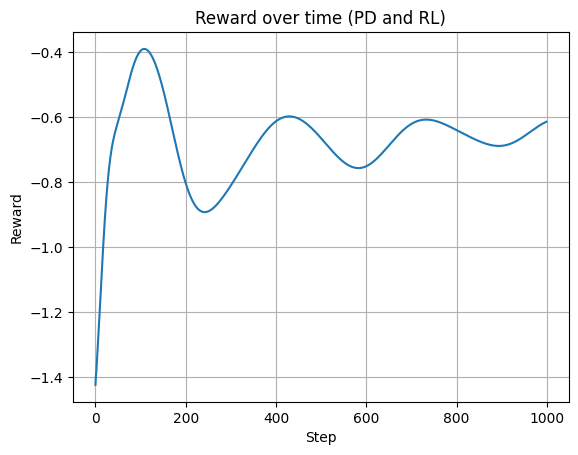

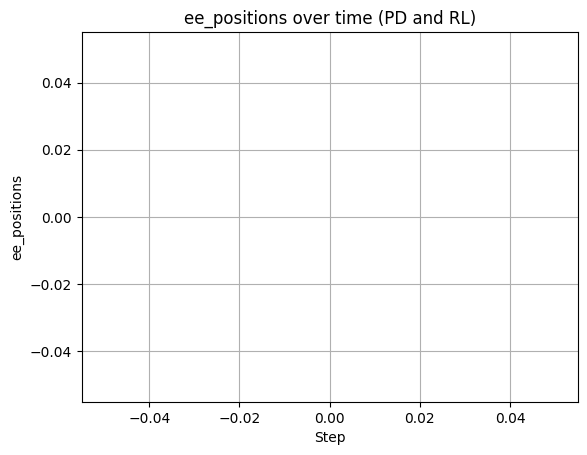

In [4]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

env = FrankaReachEnv(render=True)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs, _ = env.reset()

rewards = []
ee_positions = []

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    rewards.append(reward)
    ee_pos = obs[7:10]
    ee_positions.append(ee_pos)
    if done:
        break

env.close()

plt.figure()
plt.plot(rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward over time (PD and RL)")
plt.grid()
plt.show()

plt.figure()
plt.plot(ee_positions)
plt.xlabel("Step")
plt.ylabel("ee_positions")
plt.title("ee_positions over time (PD and RL)")
plt.grid()
plt.show()